# ttbar Analysis - Jet-Parton Assignment Training

This is the training notebook for the jet-parton assignment task. The goal is to associate the leading four jets in each event to their associated parent particles. We are trying to assign jets according to the labels in the diagram below:

<img src="utils/ttbar.png" alt="ttbar_labels" width="500"/>

top1 and top2 jets do not necessarily correspond to top/antitop, respectively. The top1 jet is defined as having a lepton/neutrino pair as cousins, where the top2 jet is defined as having two jets as cousins. The W jets are not distinguished from each other.

The strategy for solving this problem is to train a boosted decision tree to find the correct assignments for each jet. Since we consider four jets per event with three unique labels (W, top1, and top2), there are twelve possible combinations of assignments:

<img src="utils/jetcombinations.png" alt="jetcombinations" width="700"/>

The combination with the highest BDT score will be selected for each event.
____

The workflow for this training notebook is outlined as follows:
* Load data and calculate training features and labels using `coffea`/`dask`
* Optimize BDT (`xgboost` model) using `hyperopt` (TODO: Track using `mlflow`)
* Save best model (TODO: save to `onnx`)

In [1]:
from coffea.nanoevents import NanoAODSchema
from coffea import processor
import awkward as ak
import numpy as np
import hist
import json
import matplotlib.pyplot as plt
import uproot
import time
import os

import utils

# ML-related imports
from dask.distributed import Client
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import ParameterSampler, train_test_split, KFold, cross_validate
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from xgboost import XGBClassifier
import onnx

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster, want to use larger number for training)
N_FILES_MAX_PER_SAMPLE = -1

# set to True for DaskExecutor
USE_DASK_PROCESSING = True

# number of cores if using FuturesExecutor
NUM_CORES = 4

# chunk size to use
CHUNKSIZE = 100_000

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

### MACHINE LEARNING OPTIONS

# enable Dask (whether to use dask for hyperparameter optimization)
USE_DASK_ML = True

# enable MLFlow logging (to store metrics and models of hyperparameter optimization trials)
USE_MLFLOW = True

# enable MLFlow model logging/registering
MODEL_LOGGING = False

# number of folds for cross-validation
N_FOLD = 5

# number of trials (per model) for hyperparameter optimization. Total number of trials will be 2*N_TRIALS
N_TRIALS = 4

# name to use for saving model to triton server
MODEL_NAME = "sigbkg_bdt"

# if True, write over previous versions of model in triton directory
WRITE_OVER = True

# number of events to train with for each model (N events = 12*N dataset)
N_EVENTS_TRAIN = 1000

In [3]:
# get dictionaries for permutation indices, associated labels, and evaluation matrices
# permutation indices correspond to the different possible combinations of jets in an event for correspondence 
# with the W boson, the top quark on the side of hadronic decay, and the top quark on the side of leptonic decay
# evaluation matrix is used to calculate the fraction of matches correct within an event
permutations_dict, labels_dict, evaluation_matrices = utils.get_permutations_dict(4, 
                                                                                  include_labels=True, 
                                                                                  include_eval_mat=True)
evaluation_matrix = evaluation_matrices[4]
print(evaluation_matrix)

number of permutations for n= 4 :  12
calculated evaluation matrix for n= 4
[[1.   0.5  0.5  0.25 0.5  0.25 0.25 0.5  0.25 0.5  0.   0.  ]
 [0.5  1.   0.25 0.5  0.25 0.5  0.5  0.25 0.5  0.25 0.   0.  ]
 [0.5  0.25 1.   0.5  0.5  0.25 0.5  0.25 0.   0.   0.25 0.5 ]
 [0.25 0.5  0.5  1.   0.25 0.5  0.25 0.5  0.   0.   0.5  0.25]
 [0.5  0.25 0.5  0.25 1.   0.5  0.   0.   0.5  0.25 0.5  0.25]
 [0.25 0.5  0.25 0.5  0.5  1.   0.   0.   0.25 0.5  0.25 0.5 ]
 [0.25 0.5  0.5  0.25 0.   0.   1.   0.5  0.5  0.25 0.25 0.5 ]
 [0.5  0.25 0.25 0.5  0.   0.   0.5  1.   0.25 0.5  0.5  0.25]
 [0.25 0.5  0.   0.   0.5  0.25 0.5  0.25 1.   0.5  0.5  0.25]
 [0.5  0.25 0.   0.   0.25 0.5  0.25 0.5  0.5  1.   0.25 0.5 ]
 [0.   0.   0.25 0.5  0.5  0.25 0.25 0.5  0.5  0.25 1.   0.5 ]
 [0.   0.   0.5  0.25 0.25 0.5  0.5  0.25 0.25 0.5  0.5  1.  ]]


In [4]:
## functions for calculating features and labels for the BDT
def training_filter(jets, electrons, muons, genparts, even):
    '''
    Filters events down to training set and calculates jet-level labels
    
    Args:
        jets: selected jets after region filter (and selecting leading four for each event)
        electrons: selected electrons after region filter
        muons: selected muons after region filter
        genparts: selected genpart after region filter
    
    Returns:
        jets, electrons, muons, labels
    '''
    #### filter genPart to valid matching candidates ####

    # get rid of particles without parents
    genpart_parent = genparts.distinctParent
    genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
    genparts = genparts[genpart_filter]
    genpart_parent = genparts.distinctParent

    # ensure that parents are top quark or W
    genpart_filter2 = ((np.abs(genpart_parent.pdgId)==6) | (np.abs(genpart_parent.pdgId)==24))
    genparts = genparts[genpart_filter2]

    # ensure particle itself is a quark
    genpart_filter3 = ((np.abs(genparts.pdgId)<7) & (np.abs(genparts.pdgId)>0))
    genparts = genparts[genpart_filter3]

    # get rid of duplicates
    genpart_filter4 = genparts.hasFlags("isLastCopy")
    genparts = genparts[genpart_filter4]
            
        
    #### get jet-level labels and filter events to training set
        
    # match jets to nearest valid genPart candidate
    nearest_genpart = jets.nearest(genparts, threshold=0.4)
    nearest_parent = nearest_genpart.distinctParent # parent of matched particle

    parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
    grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

    grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience

    # if particle has a cousin that is a lepton
    has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                axis=-1)>0)
    # if particle has a cousin that is a neutrino
    has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & (grandchildren_flat>10) & (grandchildren_flat<19)),
                                  axis=-1)>0)

    # if a particle has a lepton cousin and a neutrino cousin
    has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False).to_numpy()

    # get labels from parent pdgId (fill none with 100 to filter out events with those jets)
    labels = np.abs(ak.fill_none(parent_pdgid,100).to_numpy())
    labels[has_both_cousins] = -6 # assign jets with both cousins as top1 (not necessarily antiparticle)

    training_event_filter = (np.sum(labels,axis=1)==48) # events with a label sum of 48 have the correct particles
            
    # filter events
    jets = jets[training_event_filter]
    electrons = electrons[training_event_filter]
    muons = muons[training_event_filter]
    labels = labels[training_event_filter]
    even = even[training_event_filter]
    
    return jets, electrons, muons, labels, even
    

def get_training_set(jets, electrons, muons, labels, permutations_dict, labels_dict):
    '''
    Calculate features for each of the 12 combinations per event and calculates combination-level labels
    
    Args:
        jets: selected jets after training filter
        electrons: selected electrons after training filter
        muons: selected muons after training filter
        labels: jet-level labels output by training_filter
    
    Returns:
        features, labels (flattened to remove event level)
    '''
    
    # calculate number of jets in each event
    njet = ak.num(jets).to_numpy()
    # don't consider every jet for events with high jet multiplicity
    njet[njet>max(permutations_dict.keys())] = max(permutations_dict.keys())
    # create awkward array of permutation indices
    perms = ak.Array([permutations_dict[n] for n in njet])
    perm_counts = ak.num(perms)
    
    
    #### calculate features ####
    
    #### calculate features ####
    features = np.zeros((sum(perm_counts),19))
    
    # grab lepton info
    leptons = ak.flatten(ak.concatenate((electrons, muons),axis=1),axis=-1)

    # delta R between top1 and lepton
    features[:,0] = ak.flatten(np.sqrt((leptons.eta - jets[perms[...,3]].eta)**2 + 
                                       (leptons.phi - jets[perms[...,3]].phi)**2)).to_numpy()

    # delta R between the two W
    features[:,1] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,1]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,1]].phi)**2)).to_numpy()

    # delta R between W and top2
    features[:,2] = ak.flatten(np.sqrt((jets[perms[...,0]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,0]].phi - jets[perms[...,2]].phi)**2)).to_numpy()
    features[:,3] = ak.flatten(np.sqrt((jets[perms[...,1]].eta - jets[perms[...,2]].eta)**2 + 
                                       (jets[perms[...,1]].phi - jets[perms[...,2]].phi)**2)).to_numpy()

    # delta phi between top1 and lepton
    features[:,4] = ak.flatten(np.abs(leptons.phi - jets[perms[...,3]].phi)).to_numpy()

    # delta phi between the two W
    features[:,5] = ak.flatten(np.abs(jets[perms[...,0]].phi - jets[perms[...,1]].phi)).to_numpy()

    # delta phi between W and top2
    features[:,6] = ak.flatten(np.abs(jets[perms[...,0]].phi - jets[perms[...,2]].phi)).to_numpy()
    features[:,7] = ak.flatten(np.abs(jets[perms[...,1]].phi - jets[perms[...,2]].phi)).to_numpy()


    # combined mass of top1 and lepton
    features[:,8] = ak.flatten((leptons + jets[perms[...,3]]).mass).to_numpy()

    # combined mass of W
    features[:,9] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]]).mass).to_numpy()

    # combined mass of W and top2
    features[:,10] = ak.flatten((jets[perms[...,0]] + jets[perms[...,1]] + 
                                 jets[perms[...,2]]).mass).to_numpy()


    # pt of every jet
    features[:,11] = ak.flatten(jets[perms[...,0]].pt).to_numpy()
    features[:,12] = ak.flatten(jets[perms[...,1]].pt).to_numpy()
    features[:,13] = ak.flatten(jets[perms[...,2]].pt).to_numpy()
    features[:,14] = ak.flatten(jets[perms[...,3]].pt).to_numpy()


    # mass of every jet
    features[:,15] = ak.flatten(jets[perms[...,0]].mass).to_numpy()
    features[:,16] = ak.flatten(jets[perms[...,1]].mass).to_numpy()
    features[:,17] = ak.flatten(jets[perms[...,2]].mass).to_numpy()
    features[:,18] = ak.flatten(jets[perms[...,3]].mass).to_numpy()
    
    #### calculate combination-level labels ####
    permutation_labels = np.array(labels_dict[4])
    
    # which combination does the truth label correspond to?
    which_combination = np.zeros(len(jets), dtype=int)
    # no correct matches
    which_anti_combination = np.zeros(labels.shape[0], dtype=int)
    for i in range(12):
        which_combination[(labels==permutation_labels[i,:]).all(1)] = i
        which_anti_combination[np.invert((labels==permutation_labels[i,:]).any(1))] = i

    # convert to combination-level truth label (-1, 0 or 1)
    which_combination = list(zip(range(len(jets),), which_combination))
    which_anti_combination = list(zip(range(labels.shape[0],), which_anti_combination))
    
    truth_labels = -1*np.ones((len(jets),12))
    for i,tpl in enumerate(which_combination):
        truth_labels[tpl]=1
    for i,tpl in enumerate(which_anti_combination):
        truth_labels[tpl]=0
        
        
    #### flatten to combinations (easy to unflatten since each event always has 12 combinations) ####
    labels = truth_labels.reshape((truth_labels.shape[0]*truth_labels.shape[1],1))
    
    return features, labels, which_combination

### Defining a `coffea` Processor

The processor returns the training features and labels we will use in our BDT

In [5]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self, permutations_dict, labels_dict):
        super().__init__()
        self.permutations_dict = permutations_dict
        self.labels_dict = labels_dict
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        xsec_weight = x_sec * lumi / nevts_total
            
        events["pt_nominal"] = 1.0
        pt_variations = ["pt_nominal"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            # filter electrons, muons, and jets by pT
            selected_electrons = events.Electron[(events.Electron.pt > 30) & (np.abs(events.Electron.eta)<2.1) & 
                                                 (events.Electron.cutBased==4) & (events.Electron.sip3d < 4)]
            selected_muons = events.Muon[(events.Muon.pt > 30) & (np.abs(events.Muon.eta)<2.1) & (events.Muon.tightId) & 
                                         (events.Muon.sip3d < 4) & (events.Muon.pfRelIso04_all < 0.15)]
            jet_filter = (events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 2.4)
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            even = (events.event%2==0)
            
            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # require at least 4 jets
            event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
            # require at least one jet above B_TAG_THRESHOLD
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            even = even[event_filters]
            
            ### only consider 4j2b region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2 # at least two b-tagged jets
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            even = even[region_filter]
            
            # filter events and calculate labels
            jets, electrons, muons, labels, even = training_filter(selected_jets_region, 
                                                                   selected_electrons_region, 
                                                                   selected_muons_region, 
                                                                   selected_genpart_region,
                                                                   even)
            
            # calculate features and labels
            features, labels, which_combination = get_training_set(jets, electrons, muons, labels,
                                                                   self.permutations_dict, self.labels_dict)
    
            # calculate mbjj
            # reconstruct hadronic top as bjj system with largest pT
            # the jet energy scale / resolution effect is not propagated to this observable at the moment
            trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
            trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
            trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
            trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
            # pick trijet candidate with largest pT and calculate mass of system
            trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
            observable = ak.flatten(trijet_mass)
            
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": col_accumulator(features.tolist()),
                  "labels": col_accumulator(labels.tolist()),
                  "observable": col_accumulator(observable.tolist()),
                  "even": col_accumulator(even.tolist())}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [6]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                  use_xcache=False)

# get rid of everything except ttbar__nominal for training purposes
fileset_keys = list(fileset.keys())
for key in fileset_keys:
    if key!="ttbar__nominal":
        fileset.pop(key)

In [7]:
fileset['ttbar__nominal']['metadata']

{'process': 'ttbar',
 'variation': 'nominal',
 'nevts': 276079127,
 'xsec': 729.84}

### Execute the data delivery pipeline

In [8]:
NanoAODSchema.warn_missing_crossrefs = False

if USE_DASK_PROCESSING:
    executor = processor.DaskExecutor(client=utils.get_client(AF))
else:
    executor = processor.FuturesExecutor(workers=NUM_CORES)
    
run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, 
                       chunksize=CHUNKSIZE)

# preprocess
filemeta = run.preprocess(fileset, treename="Events")

# process
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier(permutations_dict, labels_dict))

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [9]:
# import pickle
# pickle.dump(output, open("output_temp.p", "wb"))

In [8]:
import pickle
output = pickle.load(open("output_temp.p", "rb"))

In [9]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
even = output['even'].value
observable = output['observable'].value

labels = labels.reshape((len(labels),))
even = np.repeat(even, 12)

In [10]:
# investigate labels
print(len(labels))
print(len(labels)/12)
print(sum(labels==1))

2401260
200105.0
200105


The key for the labeling scheme is as follows

* 1: all jet assignments are correct
* 0: some jet assignments are correct (one or two are correct, others are incorrect)
* -1: all jet assignments are incorrect

There are twelve combinations for each event, so each event will have 1 correct combination, 2 completely incorrect combinations, and 9 partially correct combinations.

# Histograms of Training Variables
To vizualize the separation power of the different variables, histograms are created for each of the three labels. Only `all_correct` and `none_correct` are used for training purposes.

In [11]:
# separate by label for plotting
all_correct = features[labels==1,:]
some_correct = features[labels==-1,:]
none_correct = features[labels==0,:]

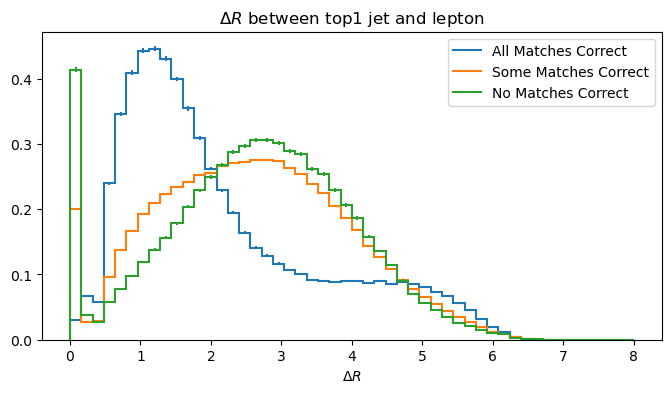

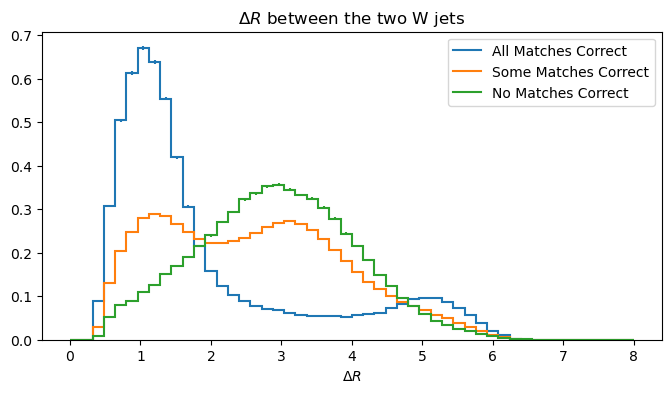

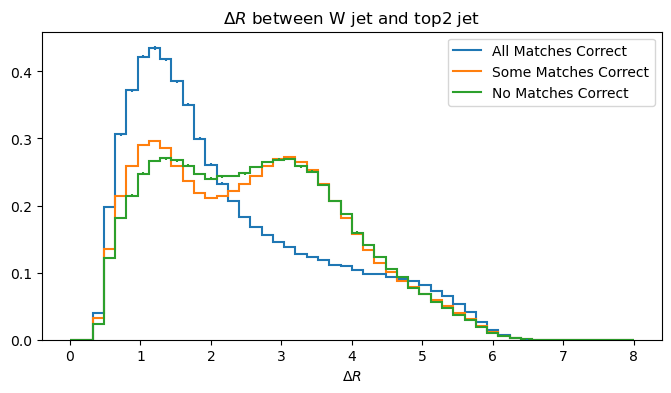

In [12]:
#### delta R histogram ####

# binning
deltar_low = 0.0
deltar_high = 8.0
deltar_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(deltar_numbins, deltar_low, deltar_high, name="deltar", label="$\Delta R$", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W"], name="category", label="Category"),
)

# fill histogram
h.fill(deltar = all_correct[:,0], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,0], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,0], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,1], category="W_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,1], category="W_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,1], category="W_W", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,2], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,2], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,2], category="top2_W", truthlabel="No Matches Correct")
h.fill(deltar = all_correct[:,3], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltar = some_correct[:,3], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltar = none_correct[:,3], category="top2_W", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between top1 jet and lepton")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between the two W jets")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top2_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta R$ between W jet and top2 jet")
fig.show()

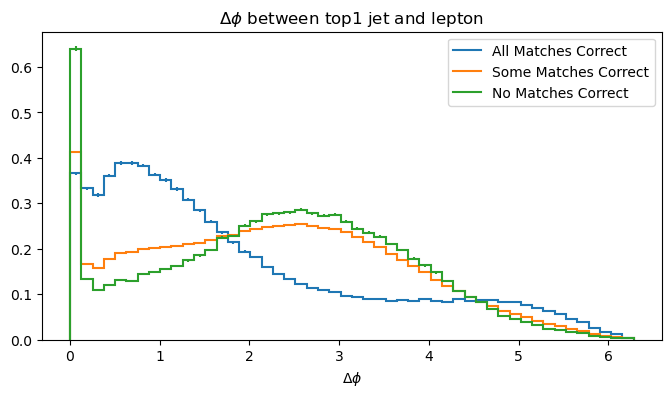

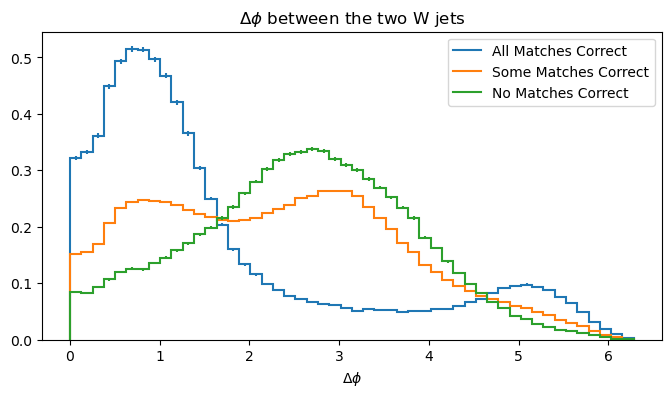

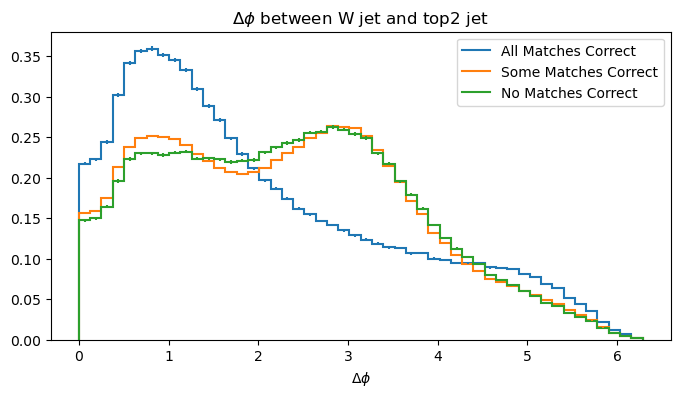

In [13]:
#### delta phi histogram ####

# binning
deltaphi_low = 0.0
deltaphi_high = 2*np.pi
deltaphi_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(deltaphi_numbins, deltaphi_low, deltaphi_high, name="deltaphi", label="$\Delta \phi$", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W"], name="category", label="Category"),
)

# fill histogram
h.fill(deltaphi = all_correct[:,4], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,4], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,4], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,5], category="W_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,5], category="W_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,5], category="W_W", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,6], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,6], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,6], category="top2_W", truthlabel="No Matches Correct")
h.fill(deltaphi = all_correct[:,7], category="top2_W", truthlabel="All Matches Correct")
h.fill(deltaphi = some_correct[:,7], category="top2_W", truthlabel="Some Matches Correct")
h.fill(deltaphi = none_correct[:,7], category="top2_W", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between top1 jet and lepton")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between the two W jets")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[0j::hist.rebin(2), :, "top2_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("$\Delta \phi$ between W jet and top2 jet")
fig.show()

/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.8/site-packages/mplhep/utils.py:245: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/conda/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning: All

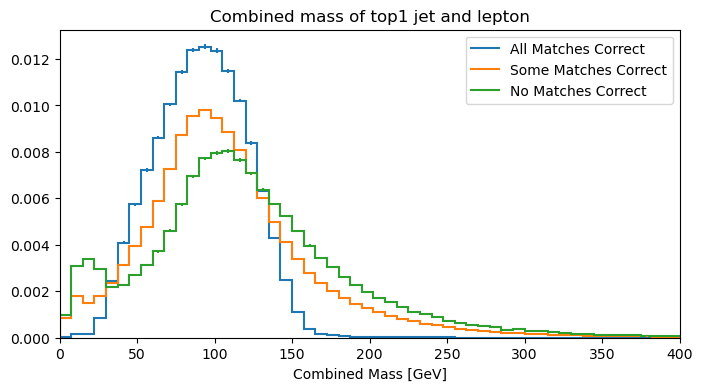

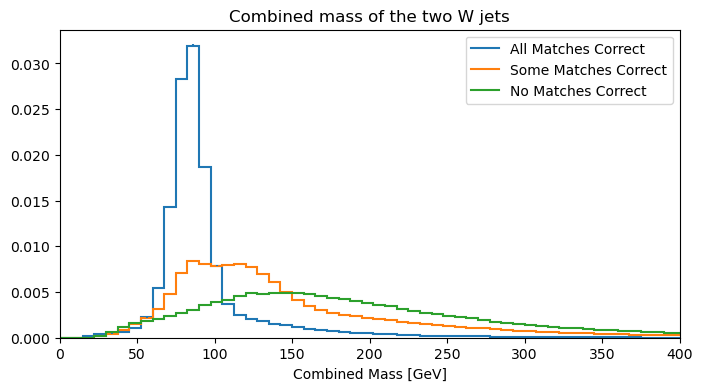

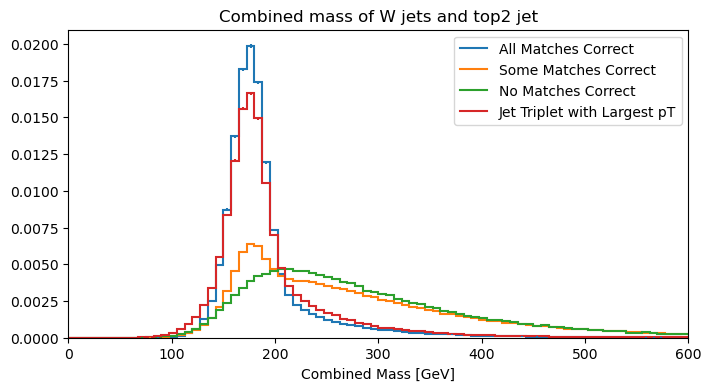

In [14]:
#### mass histogram ####

# binning
combinedmass_low = 0.0
combinedmass_high = 1500.0
combinedmass_numbins = 200
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct", "Jet Triplet with Largest pT"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(combinedmass_numbins, combinedmass_low, combinedmass_high, 
                      name="combinedmass", label="Combined Mass [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["top1_lepton","W_W","top2_W_W"], name="category", label="Category"),
)

# fill histogram
h.fill(combinedmass = all_correct[:,8], category="top1_lepton", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,8], category="top1_lepton", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,8], category="top1_lepton", truthlabel="No Matches Correct")
h.fill(combinedmass = all_correct[:,9], category="W_W", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,9], category="W_W", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,9], category="W_W", truthlabel="No Matches Correct")
h.fill(combinedmass = all_correct[:,10], category="top2_W_W", truthlabel="All Matches Correct")
h.fill(combinedmass = some_correct[:,10], category="top2_W_W", truthlabel="Some Matches Correct")
h.fill(combinedmass = none_correct[:,10], category="top2_W_W", truthlabel="No Matches Correct")
h.fill(combinedmass = observable, category="top2_W_W", truthlabel="Jet Triplet with Largest pT")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1_lepton"].plot(density=True, ax=ax)
ax.legend(legend_list[:-1])
ax.set_title("Combined mass of top1 jet and lepton")
ax.set_xlim([0,400])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W_W"].plot(density=True, ax=ax)
ax.legend(legend_list[:-1])
ax.set_title("Combined mass of the two W jets")
ax.set_xlim([0,400])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top2_W_W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("Combined mass of W jets and top2 jet")
ax.set_xlim([0,600])
fig.show()

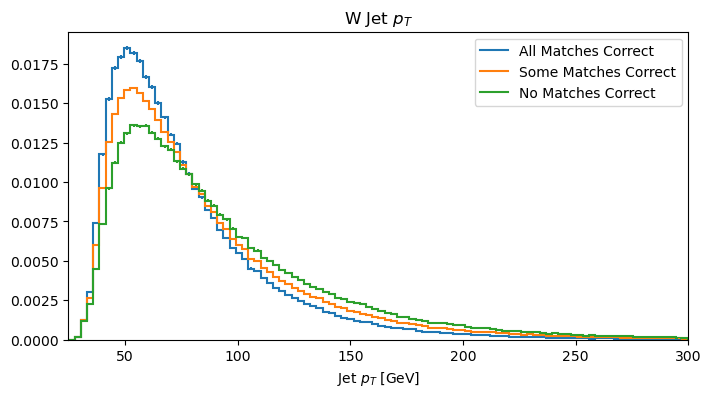

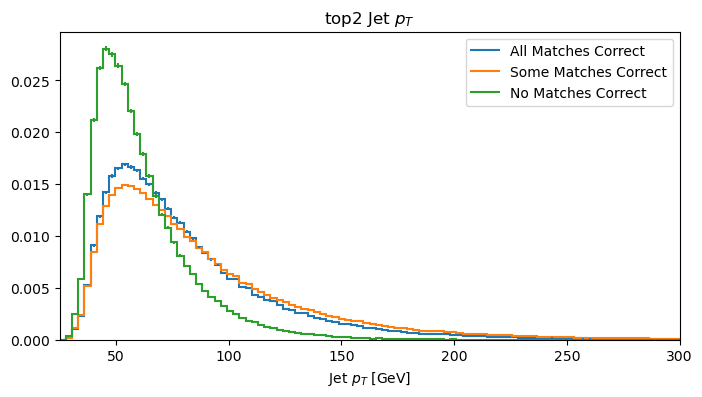

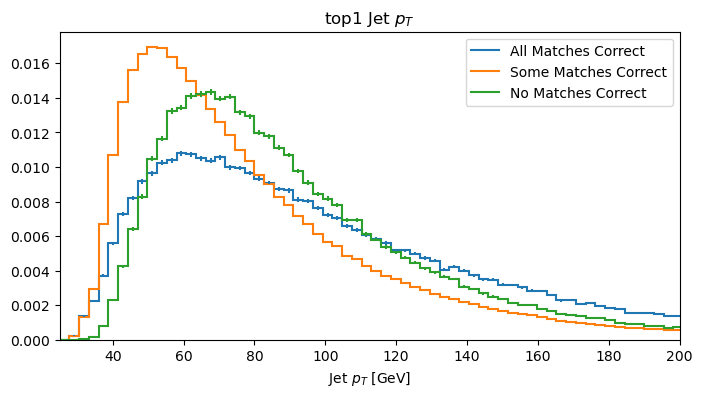

In [15]:
#### pT histogram ####

# binning
pt_low = 25.0
pt_high = 300.0
pt_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(pt_numbins, pt_low, pt_high, 
                      name="jetpt", label="Jet $p_T$ [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["W","top1","top2"], name="category", label="Category"),
)

# fill histogram
h.fill(jetpt = all_correct[:,11], category="W", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,11], category="W", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,11], category="W", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,12], category="W", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,12], category="W", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,12], category="W", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,13], category="top2", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,13], category="top2", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,13], category="top2", truthlabel="No Matches Correct")
h.fill(jetpt = all_correct[:,14], category="top1", truthlabel="All Matches Correct")
h.fill(jetpt = some_correct[:,14], category="top1", truthlabel="Some Matches Correct")
h.fill(jetpt = none_correct[:,14], category="top1", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("W Jet $p_T$")
ax.set_xlim([25,300])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top2"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top2 Jet $p_T$")
ax.set_xlim([25,300])
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top1 Jet $p_T$")
ax.set_xlim([25,200])
fig.show()

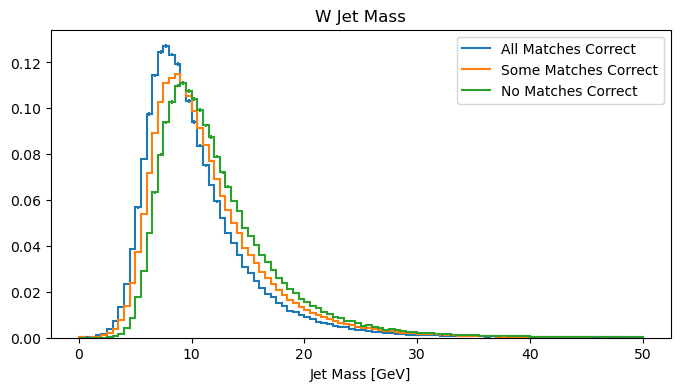

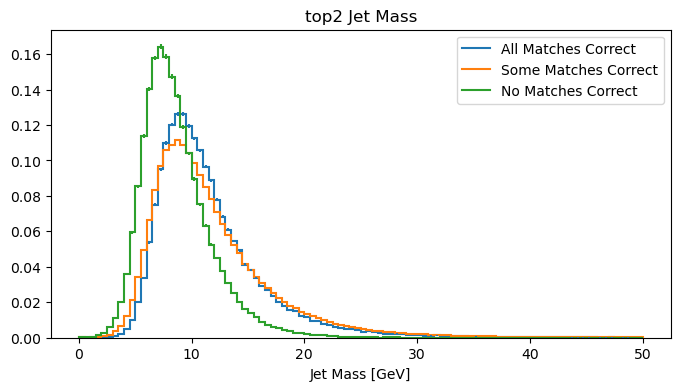

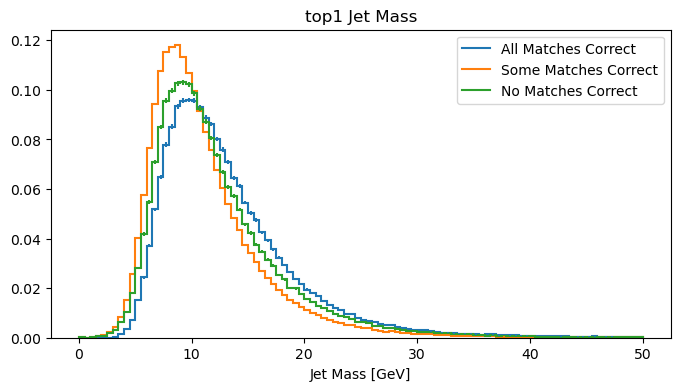

In [16]:
#### mass histogram ####

# binning
mass_low = 0.0
mass_high = 50.0
mass_numbins = 100
legend_list = ["All Matches Correct", "Some Matches Correct", "No Matches Correct"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(mass_numbins, mass_low, mass_high, 
                      name="jetmass", label="Jet Mass [GeV]", flow=False),
    hist.axis.StrCategory(legend_list, name="truthlabel", label="Truth Label"),
    hist.axis.StrCategory(["W","top1","top2"], name="category", label="Category"),
)

# fill histogram
h.fill(jetmass = all_correct[:,15], category="W", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,15], category="W", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,15], category="W", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,16], category="W", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,16], category="W", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,16], category="W", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,17], category="top2", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,17], category="top2", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,17], category="top2", truthlabel="No Matches Correct")
h.fill(jetmass = all_correct[:,18], category="top1", truthlabel="All Matches Correct")
h.fill(jetmass = some_correct[:,18], category="top1", truthlabel="Some Matches Correct")
h.fill(jetmass = none_correct[:,18], category="top1", truthlabel="No Matches Correct")

# make plots
fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "W"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("W Jet Mass")
# fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top2"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top2 Jet Mass")
fig.show()

fig,ax = plt.subplots(1,1,figsize=(8,4))
h[:, :, "top1"].plot(density=True, ax=ax)
ax.legend(legend_list)
ax.set_title("top1 Jet Mass")
fig.show()

# Model Optimization

The model used here is `xgboost`'s gradient-boosted decision tree (`XGBClassifier`). Hyperparameter optimization is performed using random selection from a sample space of hyperparameters then testing model fits in a parallelized manner using `dask`. Optional `mlflow` logging is included.

In [17]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
labels[labels==-1]=0 # partially correct = wrong
even = output['even'].value

features = features.reshape((int(features.shape[0]/12),12,19))
labels = labels.reshape((int(labels.shape[0]/12),12))

shuffle_indices = np.array(range(features.shape[0])).astype(int)
np.random.shuffle(shuffle_indices)

features = features[shuffle_indices]
labels = labels[shuffle_indices]
which_combination = np.argmax(labels,axis=-1)
even = even[shuffle_indices]

features_even = features[even]
features_even = features_even.reshape((int(12*features_even.shape[0]),19))
labels_even = labels[even]
labels_even = labels_even.reshape((int(12*labels_even.shape[0]),))
which_combination_even = which_combination[even]

features_odd = features[np.invert(even)]
features_odd = features_odd.reshape((int(12*features_odd.shape[0]),19))
labels_odd = labels[np.invert(even)]
labels_odd = labels_odd.reshape((int(12*labels_odd.shape[0]),))
which_combination_odd = which_combination[np.invert(even)]

print("features_even.shape = ", features_even.shape)
print("features_odd.shape = ", features_odd.shape)

features_even.shape =  (1199604, 19)
features_odd.shape =  (1201656, 19)


In [18]:
# preprocess features so that they are more Gaussian-like
power = PowerTransformer(method='yeo-johnson', standardize=True)

features_even = power.fit_transform(features_even)
features_odd = power.fit_transform(features_odd)

In [37]:
# define environment variables locally
%env MLFLOW_TRACKING_URI=https://mlflow.software-dev.ncsa.cloud
%env MLFLOW_S3_ENDPOINT_URL=https://mlflow-minio-api.software-dev.ncsa.cloud
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=

env: MLFLOW_TRACKING_URI=https://mlflow.software-dev.ncsa.cloud
env: MLFLOW_S3_ENDPOINT_URL=https://mlflow-minio-api.software-dev.ncsa.cloud
env: AWS_ACCESS_KEY_ID=
env: AWS_SECRET_ACCESS_KEY=


In [20]:
# set up trials
if USE_MLFLOW:
    mlflow.set_tracking_uri('https://mlflow.software-dev.ncsa.cloud') 
    mlflow.set_experiment("optimize-reconstruction-bdt-00") # this will create the experiment if it does not yet exist

    # grab experiment
    current_experiment=dict(mlflow.get_experiment_by_name("optimize-reconstruction-bdt-00"))
    experiment_id=current_experiment['experiment_id']
    print("experiment_id = ", experiment_id)

    # create runs ahead of time (avoids conflicts when parallelizing mlflow logging)
    run_id_list=[]
    for n in range(N_TRIALS*2):
        run = MlflowClient().create_run(experiment_id=experiment_id, run_name=f"run-{n}")
        run_id_list.append(run.info.run_id)

experiment_id =  6


In [21]:
sampler = ParameterSampler({'max_depth': np.arange(2,30,2,dtype=int), 
                            'n_estimators': np.arange(50,700,20,dtype=int), 
                            'learning_rate': np.logspace(-5, -1, 10),
                            'min_child_weight': np.logspace(-1, 2, 20), 
                            'reg_lambda': [0, 0.25, 0.5, 0.75, 1], 
                            'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                            'gamma': np.logspace(-4, 1, 20),
                            'tree_method': ["hist"],}, 
                            n_iter = N_TRIALS, 
                            random_state=34) 

samples_even = list(sampler)
samples_odd = list(sampler)

# add additional info to each trial
for i in range(N_TRIALS):
    samples_even[i]['trial_num'] = i
    samples_even[i]['parity'] = 'even' # categorizes this trial as for even event numbers
    
    samples_odd[i]['trial_num'] = i
    samples_odd[i]['parity'] = 'odd' # categorizes this trial as for odd event numbers
    
    if USE_MLFLOW: 
        samples_even[i]['run_id'] = run_id_list[i]
        samples_odd[i]['run_id'] = run_id_list[i+N_TRIALS]
    
print("Example of Trial Parameters: ")
samples_even[0]

Example of Trial Parameters: 


{'tree_method': 'hist',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'n_estimators': 550,
 'min_child_weight': 0.42813323987193935,
 'max_depth': 28,
 'learning_rate': 0.0016681005372000592,
 'gamma': 0.26366508987303583,
 'trial_num': 0,
 'parity': 'even',
 'run_id': '6b510d1fa95d42aab806bdc13c0b89cd'}

In [22]:
if USE_MLFLOW:
    # set mlflowclient
    mlflowclient = MlflowClient()
else: 
    mlflowclient = None

In [23]:
def modified_cross_validation(model, 
                              features, labels, 
                              evaluation_matrix, n_folds=2):
        
    features = features.reshape((int(features.shape[0]/12),12,19))
    labels = labels.reshape((int(labels.shape[0]/12),12))
    which_combination = np.argmax(labels, axis=-1)
        
    shuffle_ind = np.array(range(features.shape[0])).astype(int)
    np.random.shuffle(shuffle_ind)
    splits = np.array_split(shuffle_ind, n_folds)
    
    test_accuracy = np.zeros(n_folds)
    test_precision = np.zeros(n_folds)
    test_recall = np.zeros(n_folds)
    test_f1 = np.zeros(n_folds)
    test_roc_auc = np.zeros(n_folds)
    test_jet_score = np.zeros(n_folds)
    
    train_accuracy = np.zeros(n_folds)
    train_precision = np.zeros(n_folds)
    train_recall = np.zeros(n_folds)
    train_f1 = np.zeros(n_folds)
    train_roc_auc = np.zeros(n_folds)
    train_jet_score = np.zeros(n_folds)
    
    for n in range(n_folds):
        
        features_test = features[splits[n]]
        features_test = features_test.reshape((12*features_test.shape[0],19))
        labels_test = labels[splits[n]]
        labels_test = labels_test.reshape((12*labels_test.shape[0],))
        which_combination_test = which_combination[splits[n]]
        
        train_ind = np.concatenate([splits[i] for i in range(n_folds) if not i==n])
        
        features_train = features[train_ind]
        features_train = features_train.reshape((12*features_train.shape[0],19))
        labels_train = labels[train_ind]
        labels_train = labels_train.reshape((12*labels_train.shape[0],))
        which_combination_train = which_combination[train_ind]
        
        model.fit(features_train, labels_train)
        
        test_predictions = model.predict(features_test)
        train_predictions = model.predict(features_train)
        
        test_accuracy[n] = accuracy_score(labels_test, test_predictions)
        test_precision[n] = precision_score(labels_test, test_predictions)
        test_recall[n] = recall_score(labels_test, test_predictions)
        test_f1[n] = f1_score(labels_test, test_predictions)
        test_roc_auc[n] = roc_auc_score(labels_test, test_predictions)
        
        train_accuracy[n] = accuracy_score(labels_train, train_predictions)
        train_precision[n] = precision_score(labels_train, train_predictions)
        train_recall[n] = recall_score(labels_train, train_predictions)
        train_f1[n] = f1_score(labels_train, train_predictions)
        train_roc_auc[n] = roc_auc_score(labels_train, train_predictions)
        
        
        test_predictions_prob = model.predict_proba(features_test)[:,0]
        train_predictions_prob = model.predict_proba(features_train)[:,0]
        test_predictions_prob = test_predictions_prob.reshape((int(test_predictions_prob.shape[0]/12),12))
        train_predictions_prob = train_predictions_prob.reshape((int(train_predictions_prob.shape[0]/12),12))
        
        train_predicted_combination = np.argmax(train_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_train))
        zipped = list(zip(which_combination_train.tolist(), train_predicted_combination.tolist()))
        for i in range(len(which_combination_train)):
            scores[i] = evaluation_matrix[zipped[i]]
        train_jet_score[n] = sum(scores)/len(scores)
        
        test_predicted_combination = np.argmax(test_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_test))
        zipped = list(zip(which_combination_test.tolist(), test_predicted_combination.tolist()))
        for i in range(len(which_combination_test)):
            scores[i] = evaluation_matrix[zipped[i]]
        test_jet_score[n] = sum(scores)/len(scores)
        
    
    return {"test_accuracy": test_accuracy, 
            "test_precision": test_precision, 
            "test_recall": test_recall,
            "test_f1": test_f1,
            "test_roc_auc": test_roc_auc,
            "test_jet_score": test_jet_score,
            "train_accuracy": train_accuracy, 
            "train_precision": train_precision, 
            "train_recall": train_recall,
            "train_f1": train_f1,
            "train_roc_auc": train_roc_auc, 
            "train_jet_score": train_jet_score,
            "model": model
           }

In [24]:
def fit_model(params, 
              features, 
              labels, 
              evaluation_matrix,
              n_folds,
              mlflowclient=None,
              use_mlflow=False,
              log_models=False): 
                    
    if use_mlflow:
        
        run_id = params["run_id"]
        
        for param_name, value in params.items():
            mlflowclient.log_param(run_id, param_name, value)
        
    # remove parameters that are not used for XGBClassifier
    params_copy = params.copy()
    params_copy.pop("trial_num")
    params_copy.pop("parity")
    if use_mlflow: params_copy.pop("run_id")
    
    # initialize model with current trial paramters
    model = XGBClassifier(random_state=5, 
                          nthread=-1,
                          **params_copy) 


    # perform n-fold cross-validation
    result = modified_cross_validation(model, features, labels,
                                      evaluation_matrix, n_folds=n_folds)
    
    if use_mlflow:
        for metric, value in result.items():
            if not metric=="model":
                mlflowclient.log_metric(run_id, metric, np.average(value))

        # manually end run
        mlflowclient.set_terminated(run_id)
        
    return {"score": np.average(result["test_jet_score"]),
            "full_result": result}

In [25]:
# function to provide necessary environment variables to workers
def initialize_mlflow(): 
    
    os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.software-dev.ncsa.cloud"
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = "https://mlflow-minio-api.software-dev.ncsa.cloud"
    os.environ['AWS_ACCESS_KEY_ID'] = ""
    os.environ['AWS_SECRET_ACCESS_KEY'] = ""
    
    mlflow.set_tracking_uri('https://mlflow.software-dev.ncsa.cloud') 
    mlflow.set_experiment("agc-training-demo")

In [26]:
if USE_DASK_ML:
    start_time = time.time() 
    
    client = utils.get_client()
    client.run(initialize_mlflow)
    
    futures = client.map(fit_model,
                         samples_even, 
                         features=features_even[:N_EVENTS_TRAIN*12], 
                         labels=labels_even[:N_EVENTS_TRAIN*12],
                         evaluation_matrix=evaluation_matrix,
                         n_folds=N_FOLD,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         log_models=MODEL_LOGGING) 

    res = client.gather(futures)
    time_elapsed = time.time() - start_time
    
else:
    start_time = time.time() 
    res = np.zeros(len(samples_even))
    for i in range(len(samples_even)):
        res[i] = fit_model(samples_even[i], 
                           features=features_even[:N_EVENTS_TRAIN*12],
                           labels=labels_even[:N_EVENTS_TRAIN*12], 
                           evaluation_matrix=evaluation_matrix,
                           n_folds=N_FOLD,
                           mlflowclient=mlflowclient,
                           use_mlflow=USE_MLFLOW,
                           model_logging=MODEL_LOGGING)
    time_elapsed = time.time() - start_time

print("Hyperparameter optimization took time = ", time_elapsed)
print()

scores = [res[i]["score"] for i in range(len(res))]
best_parameters_even = samples_even[np.argmax(scores)]
print("best_parameters_even = ")
best_parameters_even

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Hyperparameter optimization took time =  107.27441215515137

best_parameters_even = 


{'tree_method': 'hist',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'n_estimators': 550,
 'min_child_weight': 0.42813323987193935,
 'max_depth': 28,
 'learning_rate': 0.0016681005372000592,
 'gamma': 0.26366508987303583,
 'trial_num': 0,
 'parity': 'even',
 'run_id': '6b510d1fa95d42aab806bdc13c0b89cd'}

In [27]:
best_model_even = res[np.argmax(scores)]["full_result"]["model"]
best_model_even.save_model("models/model_xgb_230301_even.model")

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:787: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


In [28]:
if USE_DASK_ML:
    start_time = time.time() 
    
    client = utils.get_client()
    client.run(initialize_mlflow)
    
    futures = client.map(fit_model,
                         samples_odd, 
                         features=features_odd[:N_EVENTS_TRAIN*12], 
                         labels=labels_odd[:N_EVENTS_TRAIN*12],
                         evaluation_matrix=evaluation_matrix,
                         n_folds=N_FOLD,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         log_models=MODEL_LOGGING) 

    res = client.gather(futures)
    time_elapsed = time.time() - start_time
    
else:
    start_time = time.time() 
    res = np.zeros(len(samples_odd))
    for i in range(len(samples_odd)):
        res[i] = fit_model(samples_odd[i], 
                           features=features_odd[:N_EVENTS_TRAIN*12],
                           labels=labels_odd[:N_EVENTS_TRAIN*12], 
                           evaluation_matrix=evaluation_matrix,
                           n_folds=N_FOLD,
                           mlflowclient=mlflowclient,
                           use_mlflow=USE_MLFLOW,
                           model_logging=MODEL_LOGGING)
    time_elapsed = time.time() - start_time

print("Hyperparameter optimization took time = ", time_elapsed)
print()

scores = [res[i]["score"] for i in range(len(res))]
best_parameters_odd = samples_odd[np.argmax(scores)]
print("best_parameters_odd = ")
best_parameters_odd

Hyperparameter optimization took time =  90.34153032302856

best_parameters_odd = 


{'tree_method': 'hist',
 'reg_lambda': 0,
 'reg_alpha': 0,
 'n_estimators': 550,
 'min_child_weight': 0.42813323987193935,
 'max_depth': 28,
 'learning_rate': 0.0016681005372000592,
 'gamma': 0.26366508987303583,
 'trial_num': 0,
 'parity': 'odd',
 'run_id': 'c2f3bd48823c46ca9de5c8588c9c9bb4'}

In [29]:
best_model_odd = res[np.argmax(scores)]["full_result"]["model"]
best_model_odd.save_model("models/model_xgb_230301_odd.model")

# Evaluation with Optimized Model

In [31]:
# make predictions
train_predicted = best_model_even.predict(features_even)
train_predicted_prob = best_model_even.predict_proba(features_even)[:, 1]
val_predicted = best_model_even.predict(features_odd)
val_predicted_prob = best_model_even.predict_proba(features_odd)[:, 1]

In [32]:
train_accuracy = accuracy_score(labels_even, train_predicted).round(3)
train_precision = precision_score(labels_even, train_predicted).round(3)
train_recall = recall_score(labels_even, train_predicted).round(3)
train_f1 = f1_score(labels_even, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_even, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_odd, val_predicted).round(3)
val_precision = precision_score(labels_odd, val_predicted).round(3)
val_recall = recall_score(labels_odd, val_predicted).round(3)
val_f1 = f1_score(labels_odd, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_odd, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

Training Accuracy =  0.912
Training Precision =  0.463
Training Recall =  0.386
Training f1 =  0.421
Training AUC =  0.809

Validation Accuracy =  0.91
Validation Precision =  0.454
Validation Recall =  0.377
Validation f1 =  0.412
Validation AUC =  0.804


In [33]:
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_odd))
zipped = list(zip(which_combination_odd.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_odd)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Validation Jet Score = ", score)

print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_even))
zipped = list(zip(which_combination_even.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_even)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Training Jet Score = ", score)

Validation Jet Score =  0.6620089276798019
How many events are 100% correct:  0.43836505622241306 , Random =  0.08333333333333333
How many events are 50% correct:  0.38504863288661645 , Random =  0.4166666666666667
How many events are 25% correct:  0.12447822005632228 , Random =  0.3333333333333333
How many events are 0% correct:  0.05210809083464819 , Random =  0.16666666666666666
Training Jet Score =  0.6665124491082057


In [34]:
# make predictions
train_predicted = best_model_odd.predict(features_odd)
train_predicted_prob = best_model_odd.predict_proba(features_odd)[:, 1]
val_predicted = best_model_odd.predict(features_even)
val_predicted_prob = best_model_odd.predict_proba(features_even)[:, 1]

In [35]:
train_accuracy = accuracy_score(labels_odd, train_predicted).round(3)
train_precision = precision_score(labels_odd, train_predicted).round(3)
train_recall = recall_score(labels_odd, train_predicted).round(3)
train_f1 = f1_score(labels_odd, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_odd, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_even, val_predicted).round(3)
val_precision = precision_score(labels_even, val_predicted).round(3)
val_recall = recall_score(labels_even, val_predicted).round(3)
val_f1 = f1_score(labels_even, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_even, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

Training Accuracy =  0.913
Training Precision =  0.471
Training Recall =  0.352
Training f1 =  0.403
Training AUC =  0.834

Validation Accuracy =  0.912
Validation Precision =  0.465
Validation Recall =  0.348
Validation f1 =  0.398
Validation AUC =  0.833


In [36]:
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_even))
zipped = list(zip(which_combination_even.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_even)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Validation Jet Score = ", score)

print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_odd))
zipped = list(zip(which_combination_odd.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_odd)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Training Jet Score = ", score)

Validation Jet Score =  0.6702736903178049
How many events are 100% correct:  0.44877809677193475 , Random =  0.08333333333333333
How many events are 50% correct:  0.38356657697040025 , Random =  0.4166666666666667
How many events are 25% correct:  0.11884922024268009 , Random =  0.3333333333333333
How many events are 0% correct:  0.048806106014984946 , Random =  0.16666666666666666
Training Jet Score =  0.6720700433401905
